### 0. Коллекция

Для экспериментов Вам предоставляется коллекция документов с исходными кодами программ взятых из одной известной системы автоматического тестирования. 
Каждый документ коллекции представлен в виде txt файла, в неизвестной кодировке, с преобладанием латинских символов. Документы даны как есть, без специальной структуры. Ознакомьтесь, пожалуйста, с содержимым нескольких из них, чтобы понять природу их происхождения. Архив с документами можно не распаковывать, а читать напрямую из кода. 

Пример чтения архива на питоне:

In [4]:
import tarfile

def read_collection():
    docs = {}
    with tarfile.open('./collection.tar.bz2', 'r:bz2') as tf:
            for ti in tf:
                byte_content = tf.extractfile(ti).read()
                docs[ti.name] = byte_content
    return docs

docs = read_collection()
print(len(docs))
print(docs['172672.txt'])

5258
b'#include <fstream>\r\nusing namespace std;\r\n\r\nvoid main(){\r\n\tint count = 0;\r\n\tfstream in("input.txt");\r\n\tofstream out("output.txt");\r\n\r\n\tin >> count;\r\n\tint* arr = new int[count + 1];\r\n\tint cur = 0;\r\n\tfor (int i = 1; i <= count, in >> cur; i++){// i=1\r\n\t\tarr[i] = cur;\r\n\t}\r\n\r\n\tbool flag = true;\r\n\tfor (int i = 1; 2*i <= count; i++){  \r\n\t\tif (2 * i + 1 <= count){\r\n\t\t\tif (arr[i] > arr[2 * i + 1])\r\n\t\t\t\tflag = false;\r\n\t\t}\r\n\t\tif (arr[i] > arr[2 * i])\r\n\t\t\tflag = false;\r\n\t}\r\n\r\n\tif (flag){\r\n\t\tout << "Yes";\r\n\t}\r\n\telse\r\n\t\tout << "No";\r\n\tin.close();\r\n\tout.close();\r\n}'


### 1. Точные дубли
Прочитайте документы и проведите простейшую нормализацию содержимого документов, которая не меняет его сути. Например, следует сделать как минимум: разбор кодировки, удаление BOM, замена табуляций и переводов строк на пробелы, удаление последовательностей пробельных символов. Но только пожалуйста никаких, прости господи, лемматизаций и стемминга.

Рассчитайте свою любимую многобитную хеш-функцию для нормализованных документов и найдите точные дубли с помощью известной структуры данных.
    
Оцените какие группы дубликатов получилось найти: количество групп, минимальный, максимальный и средний размер.
    
Оставьте из каждой группы один документ для дальнейших заданий.

Ну и чего я тут сделал:

1) расдекодил с помощью detect

2) заменил '\n', '\r', '\t' на пробельчики

3) убрал {, }, так как в случаях одной строки их может не быть

4) убрал мульти пробелы

5) убрал пробелы до и после всех скобок, арифметических операций, стрелок, точки с запятой и тд, так как их можно ставить как хочешь 

In [5]:
import hashlib
from itertools import groupby
from chardet import detect
import re

def decode(b):
    encoding = detect(b)['encoding']
    return b.decode(encoding)


def normalize(s1):
    for c in ['\n', '\r', '\t']:
        s1 = s1.replace(c, ' ')
    s1 = s1.replace('}', '').replace('{', '')
    s1 = re.sub(' +', ' ', s1)
    s1 = re.sub(r'([\[\(\]\)=\*-\:\/<>;\/])\s', lambda x: x.group().strip(), s1)
    s1 = re.sub(r'\s([\[\(\]\)=\*-\:\/<>;\/])', lambda x: x.group().strip(), s1)
    
    return s1


def bytes2hash(b):
    norm_b = normalize(decode(b))
    return hashlib.sha224(norm_b).hexdigest()


def fully_duplicates(docs, normalize_fn):
    flipped = {} 

    for k, v in docs.items():
        norm_value = normalize_fn(decode(v))
        if norm_value not in flipped: 
            flipped[norm_value] = [k] 
        else: 
            flipped[norm_value].append(k) 

    duplicates = []

    for _, v in flipped.items():
        if len(v) > 1:
            duplicates.append(v)
            
    return duplicates


def drop_duplicates(docs, duplicates):
    cleared_docs = docs.copy()
    for d in duplicates:
        for name in d[1:]:
            cleared_docs.pop(name)
    return cleared_docs


def duplicates2plot(duplicates):
    import matplotlib.pyplot as plt
    %matplotlib inline

    lengths = [len(d) for d in duplicates]
    plt.hist(lengths)
    print(f'number of groups: {len(duplicates)}')
    plt.ylabel('Count')
    plt.xlabel('Group Size');

Получилось 167 групп дубликатов, максимальный размер 9, минимальный - 2

number of groups: 167


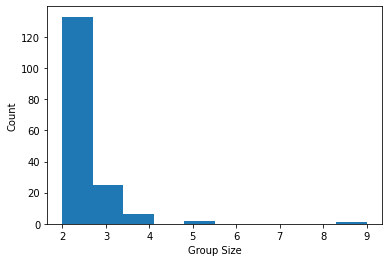

In [6]:
duplicates = fully_duplicates(docs, normalize)
duplicates2plot(duplicates)

### 2. Ground truth
В файле ground_truth.tsv.bz2 содержится результат работы «тяжелого» алгоритма сравнения документов на дубли для всех пар документов. 
Каждая строка файла описывает список потенциальных дубликатов для одного из документов коллекции. Строка файла разбита на колонки символом табуляции. В первой колонке записано имя документа, для которого далее следует список дублей. Далее в каждой колонке записано имя файла и оценка задублированности через символ = (равно). Оценка находится в пределах от 0 до 1. Далее будем называть содержимое этого файла -  ground truth.

Пример чтения архива на питоне:

In [7]:
import bz2
import time


def parse_single_result(note):
    return note.split('=')
    
def parse_ground_truth_line(line):
    items = line.decode().strip().split('\t')
    doc_id = items[0]
    result = [parse_single_result(item) for item in items[1:]]
    return doc_id, {key: float(value) for key, value in result}

def read_ground_truth():
    ground_truth = {}
    bz_file = bz2.BZ2File('./ground_truth.tsv.bz2')
    items = (parse_ground_truth_line(line) for line in bz_file.readlines())
    return dict(items)

ground_truth = read_ground_truth()      
for doc_id in ground_truth:
    for other_id in ground_truth[doc_id]:
        assert ground_truth[other_id][doc_id] ==  ground_truth[doc_id][other_id]
        
print('Ground truth size', len(ground_truth))

Ground truth size 5258


Для каждой пары документов, которые Вы посчитали дублем в пункте 1, убедитесь, что данная пара есть в ground truth и что значение равно единице (aka полные дубли).

Так как точные дубли не представляют интереса для поиска неточных дублей исключите из ground truth пары, найденные в пункте 1.

Так, а вот тут формируются пары дубликатов, проверяется, что в ground_truth они единицы, и происходит удаление из ground_truth

In [8]:
def duplicates2pairs(duplicates):
    full_duplicates = []
    for d in duplicates:
        for i in range(len(d)):
            for j in range(len(d)):
                if i != j:
                    full_duplicates.append((d[i], d[j]))

    return full_duplicates

for k, v in duplicates2pairs(duplicates):
    assert ground_truth[k][v] == 1.0
    ground_truth[k].pop(v)
    
ground_truth = drop_duplicates(ground_truth, duplicates)
cleared_docs = drop_duplicates(docs, duplicates)
print('Ground truth size', len(ground_truth))

Ground truth size 5041


### 3. MinHash
Разбейте документ на слова с учетом специфики содержимого документов: разделения по пробелам может быть недостаточно. Также учтите, что пунктуационные "слова" не менее важны в этой задаче, чем буквенные. 
Рассчитайте MinHash описанный на лекции для всех документов. Разбейте документы по дублям из расчета, что дубли имеют одинаковый MinHash.

In [9]:
import re
import random


def str2hash(s):
    return int(hashlib.sha1(s.encode()).hexdigest(), 16)


def generate_ngrams(s, n=4):
    tokens = [token for token in re.split('([\[\(\]\)\=\-\:\/\<\>\;\*])', s) if not (token == "" or token == " ")]
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [str2hash(" ".join(ngram)) for ngram in ngrams]


def generate_hash_funcs(n=100):
    return [universal_hashing() for _ in range(n)]


def universal_hashing():
    def rand_prime():
        while True:
            p = random.randrange(2 ** 32, 2 ** 34, 2)
            if all(p % n != 0 for n in range(3, int((p ** 0.5) + 1), 2)):
                return p
    m = 2 ** 32 - 1
    p = rand_prime()
    a = random.randint(0, p)
    if a % 2 == 0:
        a += 1
    b = random.randint(0, p)
    def h(x):
        return ((a * x + b) % p) % m
    return h
    

def get_min_hashes(hash_funcs, ngrams):
    return [min([h(e) for e in ngrams]) for h in hash_funcs]


def bytes2min_hash(b, hash_funcs, normalize_fn):
    ngrams = generate_ngrams(normalize_fn(decode(b)))
    return get_min_hashes(hash_funcs, ngrams)


def similarity(m1, m2):
    n = len(m1)
    return sum(int(m1[i] == m2[i]) for i in range(n)) / n

In [13]:
fns = generate_hash_funcs()
min_hashed_dict = {} 
doc_hash_dict = {}

for k, v in cleared_docs.items():
    h = tuple(bytes2min_hash(v, fns, normalize))
    doc_hash_dict[k] = h
    if h not in min_hashed_dict: 
        min_hashed_dict[h] = [k] 
    else: 
        min_hashed_dict[h].append(k)

number of groups: 10


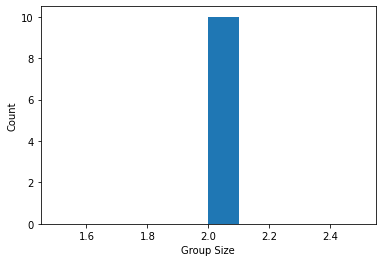

In [14]:
mh_duplicates = []

for _, v in min_hashed_dict.items():
    if len(v) > 1:
        mh_duplicates.append(v)

duplicates2plot(mh_duplicates)

In [15]:
for k, v in duplicates2pairs(mh_duplicates):
    assert ground_truth[k][v] == 1.0

Реализуйте поиск ближайших документов для произвольного количества MinHash хеш-функций (k). Отсортируйте документы кандидаты по убыванию степени задублированности – доле совпавших хешей из k. Алгоритм поиска дублей для одного документа должен быть заметно быстрее, чем линейный проход по всем другим документам коллекции.

такс, lookup_hashes ищет ближайшие документы по хэшам

In [16]:
import itertools
import collections 

def lookup_hashes(hash_value_maps, name, h):
    length = len(h)
    similars = [list() for _ in range(length)]
    for i, val in enumerate(h):
        similars[i] = hash_value_maps[i][val] if val in hash_value_maps[i] else []
    counter = collections.Counter(filter(lambda x: x != name, sum(similars, [])))
    top_dict = {k:v / length for (k,v) in dict(counter).items()}
    return top_dict

Оцените качество подбора дубликатов при различных значениях k. Например, для k равных 1, 10, 50, 100. Для оценки качества воспользуйтесь списком ground truth. В качестве метрики качества предлагается использовать nDCG@10 где релевантностью выступает оценка задублированности из ground truth. Для кандидатов, которых нет в ground truth оценку задублированности стоит считать равной нулю. 


Пример рассчета ndcg10 на питоне.

In [17]:
import numpy as np
np.random.seed(42)

def dcg_score(relevs, p):
    score = 0
    for position, relev in enumerate(relevs[:p]):
        score += (2.0 ** relev - 1) / np.log2(position + 2)
    return score

def idcg10_single_doc(ref_doc_id, ground_truth):
    return dcg_score(sorted(ground_truth[ref_doc_id].values(), reverse=True), 10)

def dcg10_single_doc(ref_doc_id, candidates_doc_ids, ground_truth):
    assert len(set(candidates_doc_ids)) == len(candidates_doc_ids), "All candidates must be different"
    return dcg_score([ground_truth[ref_doc_id].get(doc_id, 0.0) for doc_id in candidates_doc_ids], 10)

def ndcg10_single_doc(ref_doc_id, candidates_doc_ids, ground_truth):
    # Полученный вашим алгоритмом dcg10
    dcg = dcg10_single_doc(ref_doc_id, candidates_doc_ids, ground_truth)
    
    # Идеальный dcg10 для этого документа
    # чтобы ускорить, стоит предпросчитать ответы
    idcg = idcg10_single_doc(ref_doc_id, ground_truth)
    
    return dcg / idcg if idcg > 1e-10 else 0.0

def ndcg10_stats(title, doc_to_candidates, ground_truth):    
    scores = []
    for doc_id, candidates in list(doc_to_candidates.items())[:10]:
        scores.append(ndcg10_single_doc(doc_id, candidates, ground_truth))
    print(title)
    print('  Average:\t', np.mean(scores))
    print('  Median: \t', np.median(scores))
    print('  Std Dev:\t', np.std(scores))
    print('  Minimum:\t', np.min(scores))
    print('  Maximum:\t', np.max(scores))

best_for_172672 = [key for key, value in sorted(ground_truth['172672.txt'].items(), key=lambda x: -x[1])]
best_for_172672_shuffled = np.array(best_for_172672[:10])
np.random.shuffle(best_for_172672_shuffled)
assert ndcg10_single_doc('172672.txt', best_for_172672, ground_truth) == 1.0
assert ndcg10_single_doc('172672.txt', best_for_172672[:10], ground_truth) == 1.0
assert 0.0 < ndcg10_single_doc('172672.txt', best_for_172672_shuffled, ground_truth) < 1.0
assert 0.0 < ndcg10_single_doc('172672.txt', best_for_172672[:9], ground_truth) < 1.0
assert 0.0 < ndcg10_single_doc('172672.txt', best_for_172672[10:], ground_truth) < 1.0
assert ndcg10_single_doc('172672.txt', [], ground_truth) == 0.0
assert ndcg10_single_doc('172672.txt', ['unknown.txt'], ground_truth) == 0.0
assert ndcg10_single_doc('172672.txt', np.random.choice(list(ground_truth), size=10, replace=False), ground_truth) == 0.0

ndcg10_stats("Ndcg@10 demo", {'172672.txt': best_for_172672, '124830.txt': []}, ground_truth);

Ndcg@10 demo
  Average:	 0.5
  Median: 	 0.5
  Std Dev:	 0.5
  Minimum:	 0.0
  Maximum:	 1.0


Вот тут вот строятся таблицы кандидатов, которые пойдут в ndcg10_stats

In [18]:
def hash_value_maps(size, doc_hash_dict):
    hash_value_maps = [dict() for _ in range(size)]
    for k, v in doc_hash_dict.items():
        for i, val in enumerate(v):
            if val not in hash_value_maps[i]: 
                hash_value_maps[i][val] = [k]
            else: 
                hash_value_maps[i][val].append(k)
    return hash_value_maps


def build_lookup_table(docs, func_count, normalize_fn):
    hash_funcs = generate_hash_funcs(n=func_count)
    doc_hash_dict = {}

    for k, v in docs.items():
        h = bytes2min_hash(v, hash_funcs, normalize)
        doc_hash_dict[k] = h
    
    hash_values = hash_value_maps(func_count, doc_hash_dict)
    lookup_table = {}
    for k, h in doc_hash_dict.items():
        sorted_ = sorted(lookup_hashes(hash_values, k, h).items(), key=lambda x: -x[1])
        lookup_table[k] = [key for key, value in sorted_]
    return lookup_table

In [19]:
table1 = build_lookup_table(cleared_docs, 1, normalize)
ndcg10_stats("Ndcg@10: 1", table1, ground_truth)

Ndcg@10: 1
  Average:	 0.20660629114477205
  Median: 	 0.10747867290287333
  Std Dev:	 0.2575947301376108
  Minimum:	 0.0
  Maximum:	 0.8209006922763384


In [20]:
table10 = build_lookup_table(cleared_docs, 10, normalize)
ndcg10_stats("Ndcg@10: 10", table10, ground_truth)

Ndcg@10: 10
  Average:	 0.3671224397540883
  Median: 	 0.35425963835463115
  Std Dev:	 0.3333512651797516
  Minimum:	 0.0
  Maximum:	 0.8209006922763384


In [21]:
table50 = build_lookup_table(cleared_docs, 50, normalize)
ndcg10_stats("Ndcg@10: 50", table50, ground_truth)

Ndcg@10: 50
  Average:	 0.39882931893520657
  Median: 	 0.4875266697173507
  Std Dev:	 0.3449335540520135
  Minimum:	 0.0
  Maximum:	 0.8209006922763384


In [22]:
table100 = build_lookup_table(cleared_docs, 100, normalize)
ndcg10_stats("Ndcg@10: 100", table100, ground_truth)

Ndcg@10: 100
  Average:	 0.4102924500224366
  Median: 	 0.4573936423121451
  Std Dev:	 0.3579960094346271
  Minimum:	 0.0
  Maximum:	 0.8332463415155831


## Дополнительно

### 4. SimHash (+1 балл)
По аналогии с пунктом 3, реализуйте предложенный на лекции алгоритм Random Hyperplane SimHash. Если алгоритм реализован правильно, то суммарное количество ноликов и единичек в хешах должно быть примерно одинаковое.
Степень «похожести» двух документов в данном случае будет доля совпавших бит в хеше. Для поиска ближайших по расстоянию Хэмминга хешей используйте приём с разбиением хеша на части.
Оцените качество подбора дубликатов для различных размеров хеша (n). Например, для n равных 16, 64, 128, 256. Для оценки качества используйте ту же метрику, что и в пункте 3.


In [23]:
#сложна

### 5. Расширенная нормализация (+0.5 балла за пункт)
Предложите и реализуйте «нормализацию» слов документа, которая устойчива к переименованию именованных сущностей документа. Проверьте на сколько увеличилась полнота срабатывания пункта 1, а также качество пунктов 3 и 4 с новой нормализацией.

Идея в том, чтоб достать все слова из кода, и заменить их на номера этих слов. Так код станет устойчивым к переименованию сущностей, и при этом между сущностями не потеряются связи

In [24]:
def normalize_words2numbers(b):
    s = normalize(b)
    all_words = set(re.findall('\w+', s))
    rep = {k:str(v) for v, k in enumerate(all_words)}
    rep = dict((re.escape(k), v) for k, v in rep.items())
    pattern = re.compile("|".join(sorted(list(rep.keys()), key=lambda x: -len(x))))
    text = pattern.sub(lambda m: rep[re.escape(m.group(0))], s)
    return text

number of groups: 168
Ground truth size 5040


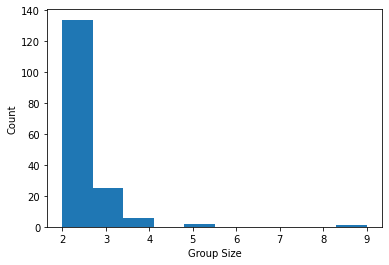

In [25]:
duplicates = fully_duplicates(docs, normalize_words2numbers)
duplicates2plot(duplicates)

ground_truth = read_ground_truth()     
for k, v in duplicates2pairs(duplicates):
    assert ground_truth[k][v] == 1.0
    ground_truth[k].pop(v)
    
ground_truth = drop_duplicates(ground_truth, duplicates)
cleared_docs = drop_duplicates(docs, duplicates)
print('Ground truth size', len(ground_truth))

Количество групп увеличилось на одну

In [26]:
table1 = build_lookup_table(cleared_docs, 1, normalize_words2numbers)
ndcg10_stats("Ndcg@10: 1", table1, ground_truth)

Ndcg@10: 1
  Average:	 0.120265977048616
  Median: 	 0.0
  Std Dev:	 0.2453804421847528
  Minimum:	 0.0
  Maximum:	 0.8209006922763384


In [27]:
table10 = build_lookup_table(cleared_docs, 10, normalize_words2numbers)
ndcg10_stats("Ndcg@10: 10", table10, ground_truth)

Ndcg@10: 10
  Average:	 0.35466873474696126
  Median: 	 0.37592505181283664
  Std Dev:	 0.32816202827153396
  Minimum:	 0.0
  Maximum:	 0.8209006922763384


In [28]:
table1 = build_lookup_table(cleared_docs, 50, normalize_words2numbers)
ndcg10_stats("Ndcg@10: 50", table1, ground_truth)

Ndcg@10: 50
  Average:	 0.40913308851248964
  Median: 	 0.511386247470709
  Std Dev:	 0.35470040020485666
  Minimum:	 0.0
  Maximum:	 0.8863193392658992


In [29]:
table1 = build_lookup_table(cleared_docs, 100, normalize_words2numbers)
ndcg10_stats("Ndcg@10: 100", table1, ground_truth)

Ndcg@10: 100
  Average:	 0.40566355664415327
  Median: 	 0.473958625940342
  Std Dev:	 0.3535482037433641
  Minimum:	 0.0
  Maximum:	 0.8304777303845237


Предложите и реализуйте удаление слов документа, которые не влияют на логику документа. Проверьте на сколько увеличилась полнота срабатывания пункта 1, а также качество пунктов 3 и 4 с новой нормализацией.

Просто разбиваю по строкам и убираю строки, которые начинаются с символов в useless (комменты и импорты)

In [30]:
useless = ('/', '#', '/*', '*', 'import')

def normalize_remove_useless(b):
    all_lines = b.split('\n')
    s = " ".join(filter(lambda l: not l.startswith(useless), all_lines))
    s = normalize(s)
    return s

number of groups: 176
Ground truth size 5025


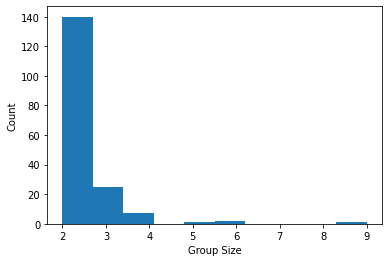

In [36]:
duplicates = fully_duplicates(docs, normalize_remove_useless)
duplicates2plot(duplicates)

ground_truth = read_ground_truth()     
for k, v in duplicates2pairs(duplicates):
    assert ground_truth[k][v] == 1.0
    ground_truth[k].pop(v)
    
ground_truth = drop_duplicates(ground_truth, duplicates)
cleared_docs = drop_duplicates(docs, duplicates)
print('Ground truth size', len(ground_truth))

А вот тут количество групп увеличилось значительно!

In [32]:
table1 = build_lookup_table(cleared_docs, 1, normalize_remove_useless)
ndcg10_stats("Ndcg@10: 1", table1, ground_truth)

Ndcg@10: 1
  Average:	 0.2230619216868277
  Median: 	 0.20331265821639477
  Std Dev:	 0.19095848935752405
  Minimum:	 0.0
  Maximum:	 0.5439133622738908


In [33]:
table1 = build_lookup_table(cleared_docs, 10, normalize_remove_useless)
ndcg10_stats("Ndcg@10: 10", table1, ground_truth)

Ndcg@10: 10
  Average:	 0.37588238697548465
  Median: 	 0.5096585402985836
  Std Dev:	 0.3203159091081704
  Minimum:	 0.0
  Maximum:	 0.8209006922763384


In [34]:
table1 = build_lookup_table(cleared_docs, 50, normalize_remove_useless)
ndcg10_stats("Ndcg@10: 50", table1, ground_truth)

Ndcg@10: 50
  Average:	 0.4110118117664422
  Median: 	 0.48542531322000015
  Std Dev:	 0.35446035923683
  Minimum:	 0.0
  Maximum:	 0.8209006922763384


In [35]:
table1 = build_lookup_table(cleared_docs, 100, normalize_remove_useless)
ndcg10_stats("Ndcg@10: 100", table1, ground_truth)

Ndcg@10: 100
  Average:	 0.4020379796168979
  Median: 	 0.4122745802476363
  Std Dev:	 0.3586703040123339
  Minimum:	 0.0
  Maximum:	 0.8209006922763384
